EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
Top-710,Sketch:8*512
Execution time: 661.671 seconds.
Top_list with 93400 bytes.
Sketch with 16960 bytes.
Total size 107.7734375 kbytes, 
Find:329
Top_ARE: 1.4360
Top_AAE: 15425.9301
Estimate time:  0.453 seconds.

For copy:
Execution time: 661.671 seconds.
Top-606,CMS:8*512
Top_list with 93400 bytes.
Sketch with 16960 bytes.
Total size 107.7734375 kbytes, 
Find 0.463 of Heavy Hitters
Top_ARE: 1.4360
Top_AAE: 15425.9301
Estimate time:  0.453 seconds.
seed:[3443173109, 4062438859, 3982078271, 2944694521, 4151716529, 2375364163, 2632029209, 4153803007]


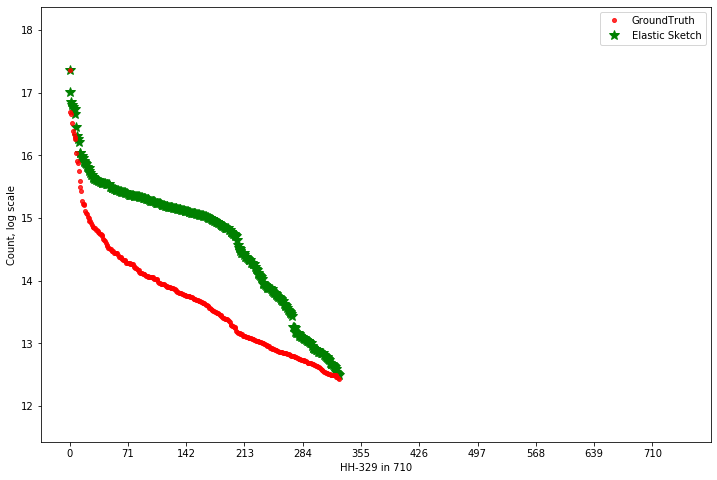

FileNotFoundError: [Errno 2] No such file or directory: '..\\result\\Ela\\caida\\HH\\8_512\\Ela_HH_710.csv'

In [1]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='caida'
# =============================dataset path and file=============================
filepath=r"..\..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='srcip\caida_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# =============================Initialize=============================
threshold=32
w=512
d=8
size=710
topk=710
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size
total_count=0
heavy_ratio=1/5000

# =============================Stream processing=============================
item_count=True
start=time.time()
for datafile in filelist[:]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while item_count:
            e=file.read(13)
            if len(e)<13:
                print('EOF')
                break
            else:    
                #item_count-=1
                total_count+=1
                e=str(e[:4])
                # =================read src ip field only===================
                index=TF.positionES(DS.Tail(e,1),1)
                    # one hash only              
                #print("index:{}".format(index))
                if Top[index]==None:
                    # bucket is empty
                    Top[index]=DS.esNode(e)
                else:
                    if Top[index].ID ==e:
                        # hit in Top
                        Top[index].vote_pos+=1
                    elif Top[index].ID !=e:
                        # e ollisions with e' at Top
                        Top[index].vote_neg+=1
                        vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                        if vote_threshold<threshold:
                            # less than threshold: send (e,1) to CMS 
                            cms.Add_CMS(DS.Tail(e,1))
                        else:
                            # larger than threshold, evict e' to CMS and set (e,1,T,1)
                            cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                            #cms.Add_CMS(e,Top[index].vote_pos)
                            Top[index]=DS.esNode(e,1,True,1)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''


EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
Top-710,Sketch:8*2048
Execution time: 582.330 seconds.
Top_list with 93160 bytes.
Sketch with 66112 bytes.
Total size 155.5390625 kbytes, 
Find:335
Top_ARE: 0.2467
Top_AAE: 2568.4269
Estimate time:  0.635 seconds.

For copy:
Execution time: 582.330 seconds.
Top-570,CMS:8*2048
Top_list with 93160 bytes.
Sketch with 66112 bytes.
Total size 155.5390625 kbytes, 
Find 0.472 of Heavy Hitters
Top_ARE: 0.2467
Top_AAE: 2568.4269
Estimate time:  0.635 seconds.
seed:[2373887561, 2512255861, 3074842999, 3964408289, 2510001433, 3647549341, 3466649423, 3292456879]


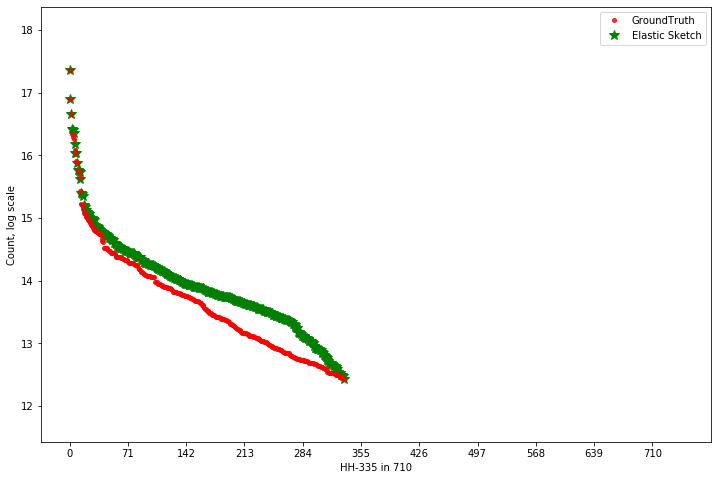

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n'

In [2]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='caida'
# =============================dataset path and file=============================
filepath=r"..\..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='srcip\caida_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# =============================Initialize=============================
threshold=32
w=2048
d=8
size=710
topk=710
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size
total_count=0
heavy_ratio=1/5000

# =============================Stream processing=============================
item_count=True
start=time.time()
for datafile in filelist[:]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while item_count:
            e=file.read(13)
            if len(e)<13:
                print('EOF')
                break
            else:    
                #item_count-=1
                total_count+=1
                e=str(e[:4])
                # =================read src ip field only===================
                index=TF.positionES(DS.Tail(e,1),1)
                    # one hash only              
                #print("index:{}".format(index))
                if Top[index]==None:
                    # bucket is empty
                    Top[index]=DS.esNode(e)
                else:
                    if Top[index].ID ==e:
                        # hit in Top
                        Top[index].vote_pos+=1
                    elif Top[index].ID !=e:
                        # e ollisions with e' at Top
                        Top[index].vote_neg+=1
                        vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                        if vote_threshold<threshold:
                            # less than threshold: send (e,1) to CMS 
                            cms.Add_CMS(DS.Tail(e,1))
                        else:
                            # larger than threshold, evict e' to CMS and set (e,1,T,1)
                            cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                            #cms.Add_CMS(e,Top[index].vote_pos)
                            Top[index]=DS.esNode(e,1,True,1)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''


EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
Top-710,Sketch:8*5500
Execution time: 594.060 seconds.
Top_list with 93136 bytes.
Sketch with 176576 bytes.
Total size 263.390625 kbytes, 
Find:314
Top_ARE: 0.0607
Top_AAE: 692.0828
Estimate time:  0.577 seconds.

For copy:
Execution time: 594.060 seconds.
Top-360,CMS:8*5500
Top_list with 93136 bytes.
Sketch with 176576 bytes.
Total size 263.390625 kbytes, 
Find 0.442 of Heavy Hitters
Top_ARE: 0.0607
Top_AAE: 692.0828
Estimate time:  0.577 seconds.
seed:[3929244853, 3671294093, 3463979219, 3128555107, 3998181293, 2952516929, 2529360881, 2765494751]


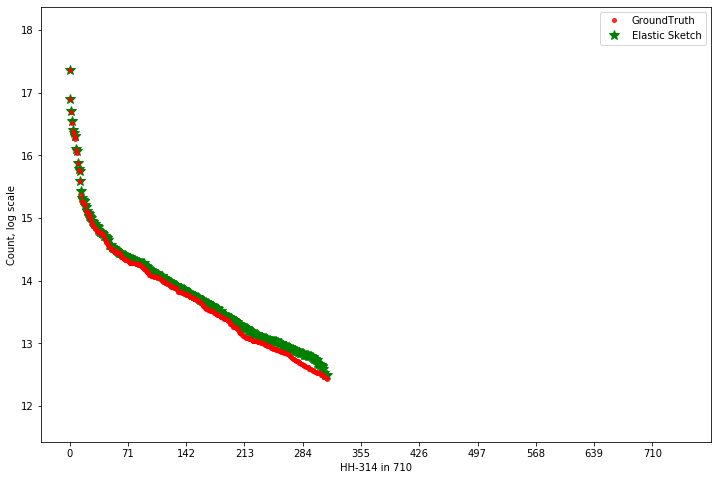

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n'

In [3]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='caida'
# =============================dataset path and file=============================
filepath=r"..\..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='srcip\caida_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# =============================Initialize=============================
threshold=32
w=5500
d=8
size=710
topk=710
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size
total_count=0
heavy_ratio=1/5000

# =============================Stream processing=============================
item_count=True
start=time.time()
for datafile in filelist[:]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while item_count:
            e=file.read(13)
            if len(e)<13:
                print('EOF')
                break
            else:    
                #item_count-=1
                total_count+=1
                e=str(e[:4])
                # =================read src ip field only===================
                index=TF.positionES(DS.Tail(e,1),1)
                    # one hash only              
                #print("index:{}".format(index))
                if Top[index]==None:
                    # bucket is empty
                    Top[index]=DS.esNode(e)
                else:
                    if Top[index].ID ==e:
                        # hit in Top
                        Top[index].vote_pos+=1
                    elif Top[index].ID !=e:
                        # e ollisions with e' at Top
                        Top[index].vote_neg+=1
                        vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                        if vote_threshold<threshold:
                            # less than threshold: send (e,1) to CMS 
                            cms.Add_CMS(DS.Tail(e,1))
                        else:
                            # larger than threshold, evict e' to CMS and set (e,1,T,1)
                            cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                            #cms.Add_CMS(e,Top[index].vote_pos)
                            Top[index]=DS.esNode(e,1,True,1)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''


EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
Top-710,Sketch:8*8900
Execution time: 584.514 seconds.
Top_list with 93088 bytes.
Sketch with 285376 bytes.
Total size 369.59375 kbytes, 
Find:340
Top_ARE: 0.0348
Top_AAE: 372.9618
Estimate time:  0.367 seconds.

For copy:
Execution time: 584.514 seconds.
Top-365,CMS:8*8900
Top_list with 93088 bytes.
Sketch with 285376 bytes.
Total size 369.59375 kbytes, 
Find 0.479 of Heavy Hitters
Top_ARE: 0.0348
Top_AAE: 372.9618
Estimate time:  0.367 seconds.
seed:[2825409283, 4182791213, 2522165599, 2869967371, 3981002537, 3812876687, 3560078363, 2686050553]


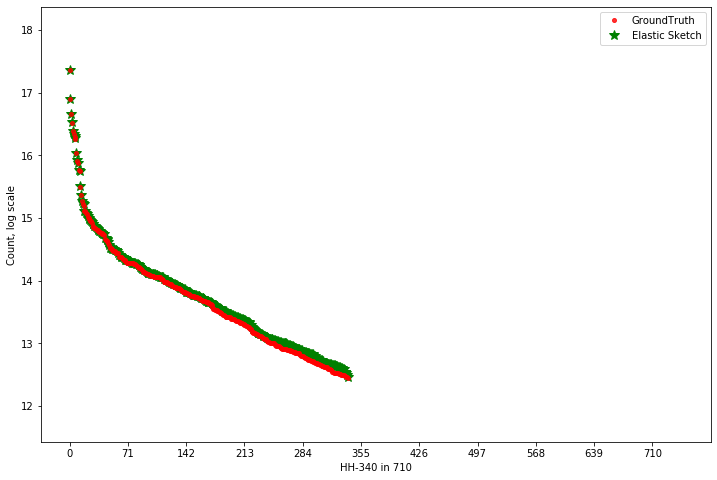

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n'

In [4]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='caida'
# =============================dataset path and file=============================
filepath=r"..\..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='srcip\caida_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# =============================Initialize=============================
threshold=32
w=8900
d=8
size=710
topk=710
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size
total_count=0
heavy_ratio=1/5000

# =============================Stream processing=============================
item_count=True
start=time.time()
for datafile in filelist[:]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while item_count:
            e=file.read(13)
            if len(e)<13:
                print('EOF')
                break
            else:    
                #item_count-=1
                total_count+=1
                e=str(e[:4])
                # =================read src ip field only===================
                index=TF.positionES(DS.Tail(e,1),1)
                    # one hash only              
                #print("index:{}".format(index))
                if Top[index]==None:
                    # bucket is empty
                    Top[index]=DS.esNode(e)
                else:
                    if Top[index].ID ==e:
                        # hit in Top
                        Top[index].vote_pos+=1
                    elif Top[index].ID !=e:
                        # e ollisions with e' at Top
                        Top[index].vote_neg+=1
                        vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                        if vote_threshold<threshold:
                            # less than threshold: send (e,1) to CMS 
                            cms.Add_CMS(DS.Tail(e,1))
                        else:
                            # larger than threshold, evict e' to CMS and set (e,1,T,1)
                            cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                            #cms.Add_CMS(e,Top[index].vote_pos)
                            Top[index]=DS.esNode(e,1,True,1)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''


EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
Top-710,Sketch:8*12300
Execution time: 501.854 seconds.
Top_list with 93112 bytes.
Sketch with 394176 bytes.
Total size 475.8671875 kbytes, 
Find:318
Top_ARE: 0.0192
Top_AAE: 210.4937
Estimate time:  0.429 seconds.

For copy:
Execution time: 501.854 seconds.
Top-336,CMS:8*12300
Top_list with 93112 bytes.
Sketch with 394176 bytes.
Total size 475.8671875 kbytes, 
Find 0.448 of Heavy Hitters
Top_ARE: 0.0192
Top_AAE: 210.4937
Estimate time:  0.429 seconds.
seed:[2890402049, 2545381621, 2284805623, 3271254403, 2347669253, 4199928311, 4171972027, 2956430159]


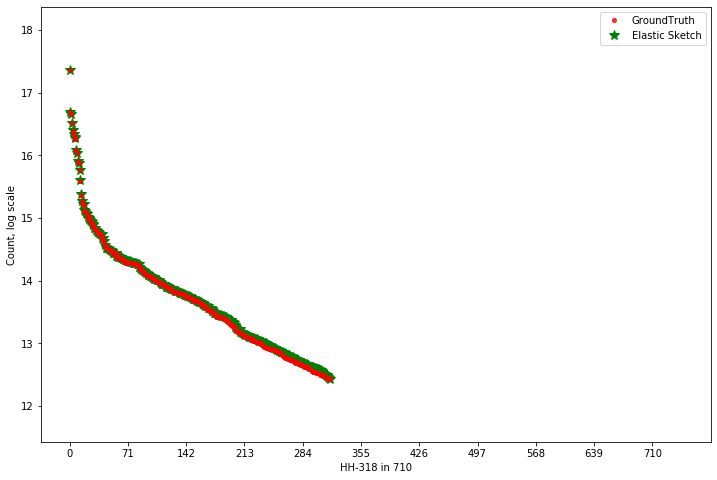

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n'

In [5]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='caida'
# =============================dataset path and file=============================
filepath=r"..\..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='srcip\caida_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# =============================Initialize=============================
threshold=32
w=12300
d=8
size=710
topk=710
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size
total_count=0
heavy_ratio=1/5000

# =============================Stream processing=============================
item_count=True
start=time.time()
for datafile in filelist[:]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while item_count:
            e=file.read(13)
            if len(e)<13:
                print('EOF')
                break
            else:    
                #item_count-=1
                total_count+=1
                e=str(e[:4])
                # =================read src ip field only===================
                index=TF.positionES(DS.Tail(e,1),1)
                    # one hash only              
                #print("index:{}".format(index))
                if Top[index]==None:
                    # bucket is empty
                    Top[index]=DS.esNode(e)
                else:
                    if Top[index].ID ==e:
                        # hit in Top
                        Top[index].vote_pos+=1
                    elif Top[index].ID !=e:
                        # e ollisions with e' at Top
                        Top[index].vote_neg+=1
                        vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                        if vote_threshold<threshold:
                            # less than threshold: send (e,1) to CMS 
                            cms.Add_CMS(DS.Tail(e,1))
                        else:
                            # larger than threshold, evict e' to CMS and set (e,1,T,1)
                            cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                            #cms.Add_CMS(e,Top[index].vote_pos)
                            Top[index]=DS.esNode(e,1,True,1)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''
彡

EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
Top-710,Sketch:8*15700
Execution time: 458.531 seconds.
Top_list with 93272 bytes.
Sketch with 502976 bytes.
Total size 582.2734375 kbytes, 
Find:314
Top_ARE: 0.0128
Top_AAE: 142.0255
Estimate time:  0.362 seconds.

For copy:
Execution time: 458.531 seconds.
Top-322,CMS:8*15700
Top_list with 93272 bytes.
Sketch with 502976 bytes.
Total size 582.2734375 kbytes, 
Find 0.442 of Heavy Hitters
Top_ARE: 0.0128
Top_AAE: 142.0255
Estimate time:  0.362 seconds.
seed:[3610417021, 2438247613, 4072732351, 2215272779, 2829443777, 3593659463, 2343653869, 2600620111]


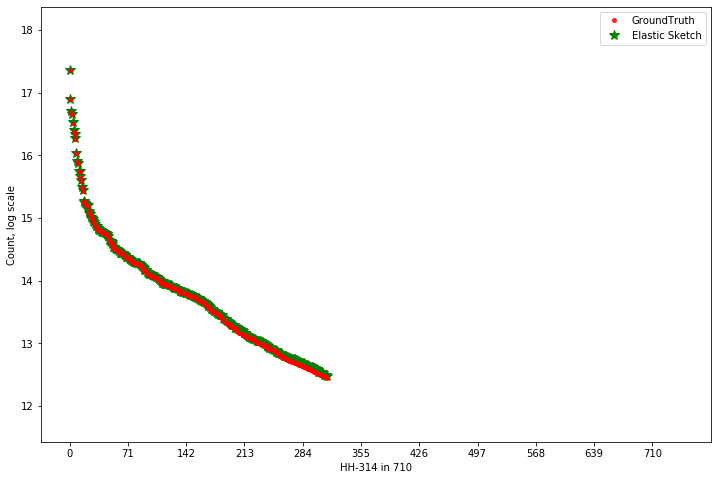

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n'

In [6]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='caida'
# =============================dataset path and file=============================
filepath=r"..\..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='srcip\caida_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# =============================Initialize=============================
threshold=32
w=15700
d=8
size=710
topk=710
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size
total_count=0
heavy_ratio=1/5000

# =============================Stream processing=============================
item_count=True
start=time.time()
for datafile in filelist[:]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while item_count:
            e=file.read(13)
            if len(e)<13:
                print('EOF')
                break
            else:    
                #item_count-=1
                total_count+=1
                e=str(e[:4])
                # =================read src ip field only===================
                index=TF.positionES(DS.Tail(e,1),1)
                    # one hash only              
                #print("index:{}".format(index))
                if Top[index]==None:
                    # bucket is empty
                    Top[index]=DS.esNode(e)
                else:
                    if Top[index].ID ==e:
                        # hit in Top
                        Top[index].vote_pos+=1
                    elif Top[index].ID !=e:
                        # e ollisions with e' at Top
                        Top[index].vote_neg+=1
                        vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                        if vote_threshold<threshold:
                            # less than threshold: send (e,1) to CMS 
                            cms.Add_CMS(DS.Tail(e,1))
                        else:
                            # larger than threshold, evict e' to CMS and set (e,1,T,1)
                            cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                            #cms.Add_CMS(e,Top[index].vote_pos)
                            Top[index]=DS.esNode(e,1,True,1)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''

EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
Top-710,Sketch:8*19100
Execution time: 467.309 seconds.
Top_list with 93296 bytes.
Sketch with 611776 bytes.
Total size 688.546875 kbytes, 
Find:318
Top_ARE: 0.0111
Top_AAE: 110.5157
Estimate time:  0.392 seconds.

For copy:
Execution time: 467.309 seconds.
Top-327,CMS:8*19100
Top_list with 93296 bytes.
Sketch with 611776 bytes.
Total size 688.546875 kbytes, 
Find 0.448 of Heavy Hitters
Top_ARE: 0.0111
Top_AAE: 110.5157
Estimate time:  0.392 seconds.
seed:[2775009401, 3923921033, 4209487057, 3202185509, 2620640801, 2403927733, 3480303887, 3924804577]


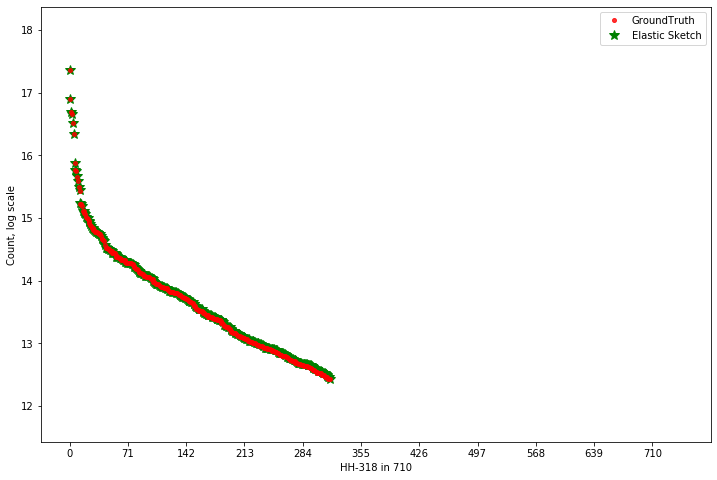

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n'

In [7]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='caida'
# =============================dataset path and file=============================
filepath=r"..\..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='srcip\caida_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# =============================Initialize=============================
threshold=32
w=19100
d=8
size=710
topk=710
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size
total_count=0
heavy_ratio=1/5000

# =============================Stream processing=============================
item_count=True
start=time.time()
for datafile in filelist[:]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while item_count:
            e=file.read(13)
            if len(e)<13:
                print('EOF')
                break
            else:    
                #item_count-=1
                total_count+=1
                e=str(e[:4])
                # =================read src ip field only===================
                index=TF.positionES(DS.Tail(e,1),1)
                    # one hash only              
                #print("index:{}".format(index))
                if Top[index]==None:
                    # bucket is empty
                    Top[index]=DS.esNode(e)
                else:
                    if Top[index].ID ==e:
                        # hit in Top
                        Top[index].vote_pos+=1
                    elif Top[index].ID !=e:
                        # e ollisions with e' at Top
                        Top[index].vote_neg+=1
                        vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                        if vote_threshold<threshold:
                            # less than threshold: send (e,1) to CMS 
                            cms.Add_CMS(DS.Tail(e,1))
                        else:
                            # larger than threshold, evict e' to CMS and set (e,1,T,1)
                            cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                            #cms.Add_CMS(e,Top[index].vote_pos)
                            Top[index]=DS.esNode(e,1,True,1)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''


EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
Top-710,Sketch:8*22500
Execution time: 450.993 seconds.
Top_list with 93120 bytes.
Sketch with 720576 bytes.
Total size 794.625 kbytes, 
Find:319
Top_ARE: 0.0083
Top_AAE: 89.3511
Estimate time:  0.421 seconds.

For copy:
Execution time: 450.993 seconds.
Top-323,CMS:8*22500
Top_list with 93120 bytes.
Sketch with 720576 bytes.
Total size 794.625 kbytes, 
Find 0.449 of Heavy Hitters
Top_ARE: 0.0083
Top_AAE: 89.3511
Estimate time:  0.421 seconds.
seed:[2342161651, 3501480919, 3537393061, 2466818531, 2383586251, 3987125041, 3981184217, 3318268823]


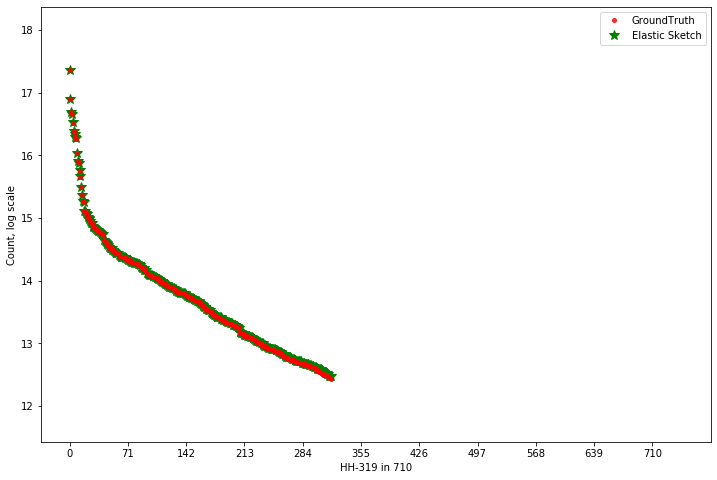

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n'

In [8]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='caida'
# =============================dataset path and file=============================
filepath=r"..\..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='srcip\caida_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# =============================Initialize=============================
threshold=32
w=22500
d=8
size=710
topk=710
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size
total_count=0
heavy_ratio=1/5000

# =============================Stream processing=============================
item_count=True
start=time.time()
for datafile in filelist[:]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while item_count:
            e=file.read(13)
            if len(e)<13:
                print('EOF')
                break
            else:    
                #item_count-=1
                total_count+=1
                e=str(e[:4])
                # =================read src ip field only===================
                index=TF.positionES(DS.Tail(e,1),1)
                    # one hash only              
                #print("index:{}".format(index))
                if Top[index]==None:
                    # bucket is empty
                    Top[index]=DS.esNode(e)
                else:
                    if Top[index].ID ==e:
                        # hit in Top
                        Top[index].vote_pos+=1
                    elif Top[index].ID !=e:
                        # e ollisions with e' at Top
                        Top[index].vote_neg+=1
                        vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                        if vote_threshold<threshold:
                            # less than threshold: send (e,1) to CMS 
                            cms.Add_CMS(DS.Tail(e,1))
                        else:
                            # larger than threshold, evict e' to CMS and set (e,1,T,1)
                            cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                            #cms.Add_CMS(e,Top[index].vote_pos)
                            Top[index]=DS.esNode(e,1,True,1)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''


EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
Top-710,Sketch:8*25900
Execution time: 451.561 seconds.
Top_list with 93128 bytes.
Sketch with 829376 bytes.
Total size 900.8828125 kbytes, 
Find:320
Top_ARE: 0.0065
Top_AAE: 69.7344
Estimate time:  0.364 seconds.

For copy:
Execution time: 451.561 seconds.
Top-323,CMS:8*25900
Top_list with 93128 bytes.
Sketch with 829376 bytes.
Total size 900.8828125 kbytes, 
Find 0.451 of Heavy Hitters
Top_ARE: 0.0065
Top_AAE: 69.7344
Estimate time:  0.364 seconds.
seed:[4076821451, 3487825771, 2745794867, 3948222557, 3547298627, 3603753011, 4125789793, 3009383291]


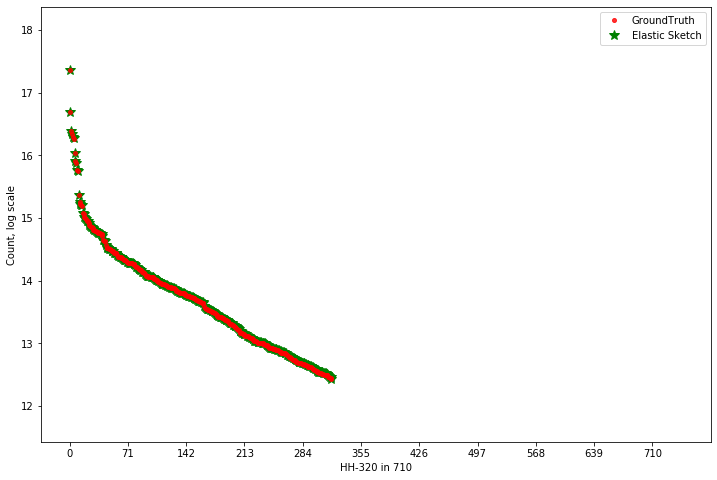

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n'

In [9]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='caida'
# =============================dataset path and file=============================
filepath=r"..\..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='srcip\caida_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# =============================Initialize=============================
threshold=32
w=25900
d=8
size=710
topk=710
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size
total_count=0
heavy_ratio=1/5000

# =============================Stream processing=============================
item_count=True
start=time.time()
for datafile in filelist[:]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while item_count:
            e=file.read(13)
            if len(e)<13:
                print('EOF')
                break
            else:    
                #item_count-=1
                total_count+=1
                e=str(e[:4])
                # =================read src ip field only===================
                index=TF.positionES(DS.Tail(e,1),1)
                    # one hash only              
                #print("index:{}".format(index))
                if Top[index]==None:
                    # bucket is empty
                    Top[index]=DS.esNode(e)
                else:
                    if Top[index].ID ==e:
                        # hit in Top
                        Top[index].vote_pos+=1
                    elif Top[index].ID !=e:
                        # e ollisions with e' at Top
                        Top[index].vote_neg+=1
                        vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                        if vote_threshold<threshold:
                            # less than threshold: send (e,1) to CMS 
                            cms.Add_CMS(DS.Tail(e,1))
                        else:
                            # larger than threshold, evict e' to CMS and set (e,1,T,1)
                            cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                            #cms.Add_CMS(e,Top[index].vote_pos)
                            Top[index]=DS.esNode(e,1,True,1)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''


EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
Top-710,Sketch:8*29300
Execution time: 470.119 seconds.
Top_list with 93160 bytes.
Sketch with 938176 bytes.
Total size 1007.1640625 kbytes, 
Find:308
Top_ARE: 0.0051
Top_AAE: 55.4643
Estimate time:  0.375 seconds.

For copy:
Execution time: 470.119 seconds.
Top-314,CMS:8*29300
Top_list with 93160 bytes.
Sketch with 938176 bytes.
Total size 1007.1640625 kbytes, 
Find 0.434 of Heavy Hitters
Top_ARE: 0.0051
Top_AAE: 55.4643
Estimate time:  0.375 seconds.
seed:[2604500627, 3144580343, 2787870017, 2374640467, 2503613323, 3616057213, 2914816691, 3395353501]


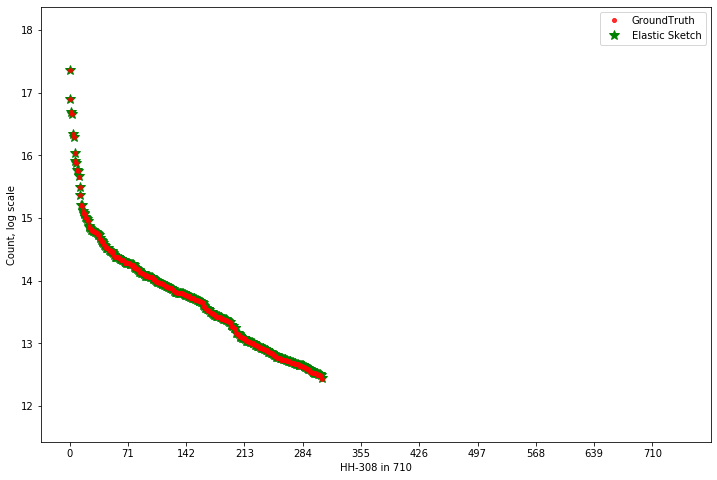

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n'

In [10]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='caida'
# =============================dataset path and file=============================
filepath=r"..\..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='srcip\caida_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# =============================Initialize=============================
threshold=32
w=29300
d=8
size=710
topk=710
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size
total_count=0
heavy_ratio=1/5000

# =============================Stream processing=============================
item_count=True
start=time.time()
for datafile in filelist[:]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while item_count:
            e=file.read(13)
            if len(e)<13:
                print('EOF')
                break
            else:    
                #item_count-=1
                total_count+=1
                e=str(e[:4])
                # =================read src ip field only===================
                index=TF.positionES(DS.Tail(e,1),1)
                    # one hash only              
                #print("index:{}".format(index))
                if Top[index]==None:
                    # bucket is empty
                    Top[index]=DS.esNode(e)
                else:
                    if Top[index].ID ==e:
                        # hit in Top
                        Top[index].vote_pos+=1
                    elif Top[index].ID !=e:
                        # e ollisions with e' at Top
                        Top[index].vote_neg+=1
                        vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                        if vote_threshold<threshold:
                            # less than threshold: send (e,1) to CMS 
                            cms.Add_CMS(DS.Tail(e,1))
                        else:
                            # larger than threshold, evict e' to CMS and set (e,1,T,1)
                            cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                            #cms.Add_CMS(e,Top[index].vote_pos)
                            Top[index]=DS.esNode(e,1,True,1)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''


EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
Top-710,Sketch:8*32700
Execution time: 448.524 seconds.
Top_list with 93200 bytes.
Sketch with 1046976 bytes.
Total size 1113.453125 kbytes, 
Find:324
Top_ARE: 0.0048
Top_AAE: 51.2994
Estimate time:  0.375 seconds.

For copy:
Execution time: 448.524 seconds.
Top-325,CMS:8*32700
Top_list with 93200 bytes.
Sketch with 1046976 bytes.
Total size 1113.453125 kbytes, 
Find 0.456 of Heavy Hitters
Top_ARE: 0.0048
Top_AAE: 51.2994
Estimate time:  0.375 seconds.
seed:[2381429263, 4118267773, 4113929333, 3408359993, 3615891079, 2439675893, 3898172351, 4100684299]


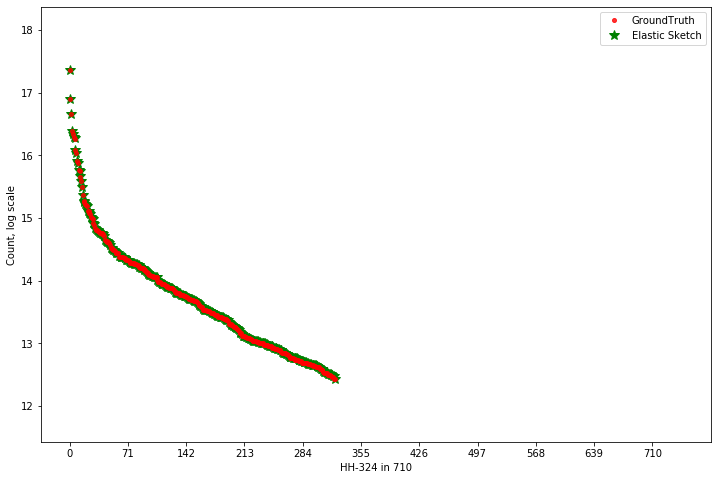

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n'

In [11]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='caida'
# =============================dataset path and file=============================
filepath=r"..\..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='srcip\caida_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# =============================Initialize=============================
threshold=32
w=32700
d=8
size=710
topk=710
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size
total_count=0
heavy_ratio=1/5000

# =============================Stream processing=============================
item_count=True
start=time.time()
for datafile in filelist[:]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while item_count:
            e=file.read(13)
            if len(e)<13:
                print('EOF')
                break
            else:    
                #item_count-=1
                total_count+=1
                e=str(e[:4])
                # =================read src ip field only===================
                index=TF.positionES(DS.Tail(e,1),1)
                    # one hash only              
                #print("index:{}".format(index))
                if Top[index]==None:
                    # bucket is empty
                    Top[index]=DS.esNode(e)
                else:
                    if Top[index].ID ==e:
                        # hit in Top
                        Top[index].vote_pos+=1
                    elif Top[index].ID !=e:
                        # e ollisions with e' at Top
                        Top[index].vote_neg+=1
                        vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                        if vote_threshold<threshold:
                            # less than threshold: send (e,1) to CMS 
                            cms.Add_CMS(DS.Tail(e,1))
                        else:
                            # larger than threshold, evict e' to CMS and set (e,1,T,1)
                            cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                            #cms.Add_CMS(e,Top[index].vote_pos)
                            Top[index]=DS.esNode(e,1,True,1)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")


'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''

EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
Top-710,Sketch:8*32700
Execution time: 514.552 seconds.
Top_list with 93160 bytes.
Sketch with 1046976 bytes.
Total size 1113.4140625 kbytes, 
Find:370
Top_ARE: 0.0058
Top_AAE: 59.1622
Estimate time:  0.396 seconds.

For copy:
Execution time: 514.552 seconds.
Top-372,CMS:8*32700
Top_list with 93160 bytes.
Sketch with 1046976 bytes.
Total size 1113.4140625 kbytes, 
Find 0.521 of Heavy Hitters
Top_ARE: 0.0058
Top_AAE: 59.1622
Estimate time:  0.396 seconds.
seed:[3512158583, 3654586051, 3822267181, 2326711459, 2440602509, 2403175039, 3922250663, 2820357499]


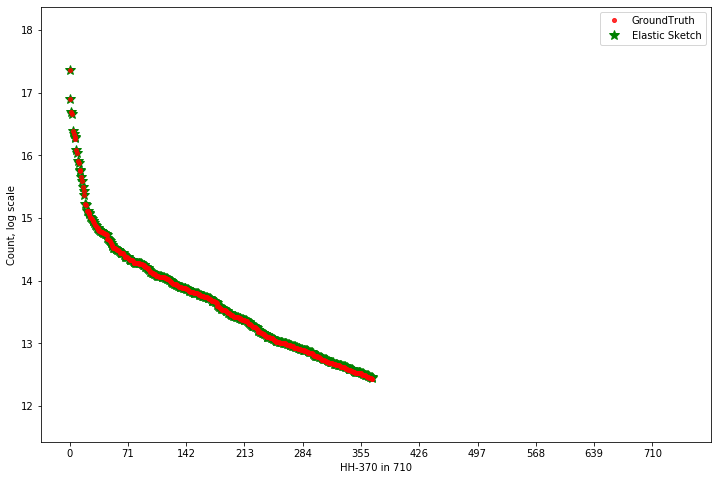

'\n# =============================result to csv=============================\nimport pandas as pd\npath="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)\n# HH to csv\nfilename=\'Ela_HH_\'+str(len(gr_set))+\'.csv\'\ntopdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\ntopdf.to_csv(os.path.join(path,filename),index=False)\n'

In [12]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='caida'
# =============================dataset path and file=============================
filepath=r"..\..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='srcip\caida_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# =============================Initialize=============================
threshold=16
w=32700
d=8
size=710
topk=710
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size
total_count=0
heavy_ratio=1/5000

# =============================Stream processing=============================
item_count=True
start=time.time()
for datafile in filelist[:]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while item_count:
            e=file.read(13)
            if len(e)<13:
                print('EOF')
                break
            else:    
                #item_count-=1
                total_count+=1
                e=str(e[:4])
                # =================read src ip field only===================
                index=TF.positionES(DS.Tail(e,1),1)
                    # one hash only              
                #print("index:{}".format(index))
                if Top[index]==None:
                    # bucket is empty
                    Top[index]=DS.esNode(e)
                else:
                    if Top[index].ID ==e:
                        # hit in Top
                        Top[index].vote_pos+=1
                    elif Top[index].ID !=e:
                        # e ollisions with e' at Top
                        Top[index].vote_neg+=1
                        vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                        if vote_threshold<threshold:
                            # less than threshold: send (e,1) to CMS 
                            cms.Add_CMS(DS.Tail(e,1))
                        else:
                            # larger than threshold, evict e' to CMS and set (e,1,T,1)
                            cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                            #cms.Add_CMS(e,Top[index].vote_pos)
                            Top[index]=DS.esNode(e,1,True,1)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")


'''
# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
'''